In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.get_cmap("Dark2").colors

In [2]:
def bezier_linear(t, c0, c1):
    return (1 - t) * c0 + t * c1

def bezier_quadratic(t, c0, c1, c2):
    return (1 - t)**2 * c0 + 2 * (1 - t) * t * c1 + t**2 * c2

def bezier_cubic(t, c0, c1, c2, c3):
    return (1 - t)**3 * c0 + 3 * (1 - t)**2 * t * c1 + 3 * (1 - t) * t**2 * c2 + t**3 * c3


In [3]:
cpoints = np.array([[0, 0], [1, 0.8], [0.8, 2.5], [0.2, 2.8]])
# matplotlib.use('pgf')

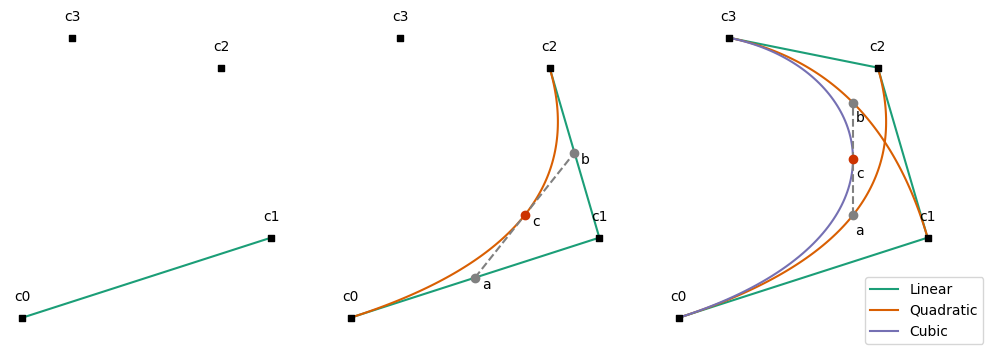

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].axis('off')
axes[0].scatter(cpoints[:, 0], cpoints[:, 1], color='black', marker='s', zorder=100, s=15)

for i in range(len(cpoints)):
    axes[0].annotate(f"c{i}", cpoints[i], xytext=(0, 10), textcoords='offset points', ha='center', va='bottom')

t = np.linspace(0, 1, 100)
l1 = np.array([bezier_linear(t, cpoints[0], cpoints[1]) for t in t])

axes[0].plot(l1[:, 0], l1[:, 1], color=cmap[0])

axes[1].axis('off')
axes[1].scatter(cpoints[:, 0], cpoints[:, 1], color='black', marker='s', zorder=100, s=15)

for i in range(len(cpoints)):
    axes[1].annotate(f"c{i}", cpoints[i], xytext=(0, 10), textcoords='offset points', ha='center', va='bottom')

t = np.linspace(0, 1, 100)
l1 = np.array([bezier_linear(t, cpoints[0], cpoints[1]) for t in t])
l2 = np.array([bezier_linear(t, cpoints[1], cpoints[2]) for t in t])
q1 = np.array([bezier_quadratic(t, cpoints[0], cpoints[1], cpoints[2]) for t in t])

axes[1].plot(l1[:, 0], l1[:, 1], color=cmap[0])
axes[1].plot(l2[:, 0], l2[:, 1], color=cmap[0])
axes[1].plot(q1[:, 0], q1[:, 1], color=cmap[1])

a1 = bezier_linear(0.5, cpoints[0], cpoints[1])
a2 = bezier_linear(0.5, cpoints[1], cpoints[2])
h1 = bezier_linear(0.5, a1, a2)

points = [a1, a2, h1]
names = ["a", "b", "c"]

for i, name in enumerate(names):
    axes[1].annotate(name, points[i], xytext=(8, -10), textcoords='offset points', ha='center', va='bottom')

axes[1].scatter(a1[0], a1[1], marker='o', zorder=100, color='grey')
axes[1].scatter(a2[0], a2[1], marker='o', zorder=100, color='grey')
axes[1].scatter(h1[0], h1[1], marker='o', zorder=100, color='#cc3300')

axes[1].plot([a1[0], a2[0]], [a1[1], a2[1]], '--', c='grey')


axes[2].axis('off')
axes[2].scatter(cpoints[:, 0], cpoints[:, 1], color='black', marker='s', zorder=100, s=15)

for i in range(len(cpoints)):
    axes[2].annotate(f"c{i}", cpoints[i], xytext=(0, 10), textcoords='offset points', ha='center', va='bottom')

t = np.linspace(0, 1, 100)
l1 = np.array([bezier_linear(t, cpoints[0], cpoints[1]) for t in t])
l2 = np.array([bezier_linear(t, cpoints[1], cpoints[2]) for t in t])
l3 = np.array([bezier_linear(t, cpoints[2], cpoints[3]) for t in t])
q1 = np.array([bezier_quadratic(t, cpoints[0], cpoints[1], cpoints[2]) for t in t])
q2 = np.array([bezier_quadratic(t, cpoints[1], cpoints[2], cpoints[3]) for t in t])
c1 = np.array([bezier_cubic(t, cpoints[0], cpoints[1], cpoints[2], cpoints[3]) for t in t])

axes[2].plot(l1[:, 0], l1[:, 1], color=cmap[0])
axes[2].plot(l2[:, 0], l2[:, 1], color=cmap[0])
axes[2].plot(l3[:, 0], l3[:, 1], color=cmap[0], label="Linear")
axes[2].plot(q1[:, 0], q1[:, 1], color=cmap[1])
axes[2].plot(q2[:, 0], q2[:, 1], color=cmap[1], label="Quadratic")
axes[2].plot(c1[:, 0], c1[:, 1], color=cmap[2], label="Cubic")

a1 = bezier_quadratic(0.5, cpoints[0], cpoints[1], cpoints[2])
a2 = bezier_quadratic(0.5, cpoints[1], cpoints[2], cpoints[3])
h1 = bezier_linear(0.5, a1, a2)

points = [a1, a2, h1]
names = ["a", "b", "c"]

for i, name in enumerate(names):
    axes[2].annotate(name, points[i], xytext=(5, -16), textcoords='offset points', ha='center', va='bottom')

axes[2].scatter(a1[0], a1[1], marker='o', zorder=100, color='grey')
axes[2].scatter(a2[0], a2[1], marker='o', zorder=100, color='grey')
axes[2].scatter(h1[0], h1[1], marker='o', zorder=100, color='#cc3300')

axes[2].plot([a1[0], a2[0]], [a1[1], a2[1]], '--', c='grey')
axes[2].legend(bbox_to_anchor=(0.7, 0.2))

plt.savefig("img/bezier.pgf")

In [1]:
from thesispy.plot_utils import *
import numpy as np
from thesispy.experiments.validation import plot_cpoints

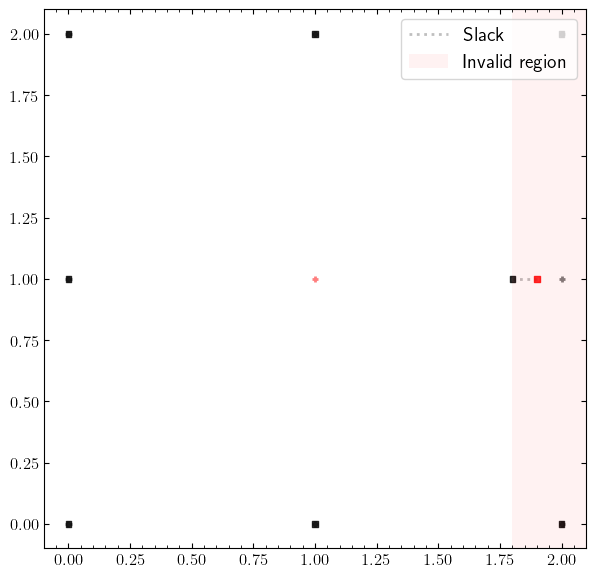

In [2]:
grid_size = 3
grid_spacing = [1, 1]
grid_origin = [-0.5, -0.5]
cpoints = np.zeros((grid_size, grid_size, 2))
cpoints[:, :, 0] = np.arange(grid_size)
cpoints[:, :, 1] = np.arange(grid_size)[:, np.newaxis]

cpoints[1, 1] = [1.9, 1.0]
cpoints[1, 2] = [1.8, 1.0]

colors = ["black" for _ in range(grid_size**2)]
colors[4] = "red"

plot_cpoints(cpoints, grid_spacing, grid_origin, colors=colors, alpha=0.5)
plt.plot([1.9, 1.8], [1.0, 1.0], ':', c='grey', zorder=-100, alpha=0.5, label="Slack")
plt.fill_between([1.8, 2.5], -0.5, 2.5, color='red', alpha=0.05, linewidth=0, label="Invalid region")

plt.xlim(-0.1, 2.1)
plt.ylim(-0.1, 2.1)

plt.legend(loc="upper right", prop={'size': 14})

plt.savefig("example_horizontal.pdf")

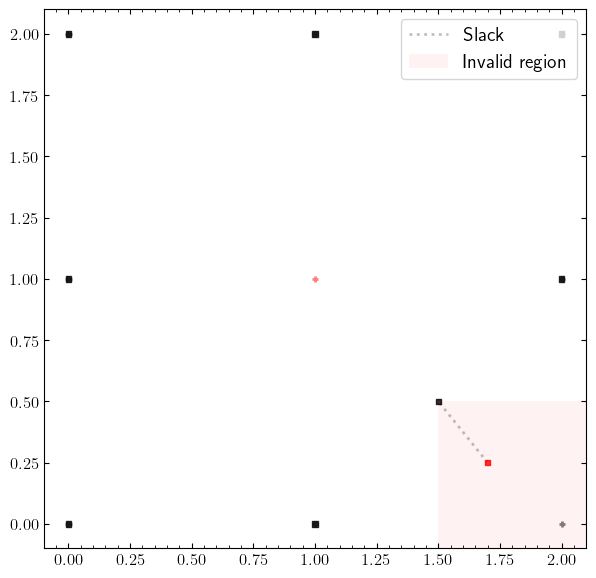

In [59]:
grid_size = 3
grid_spacing = [1, 1]
grid_origin = [-0.5, -0.5]
cpoints = np.zeros((grid_size, grid_size, 2))
cpoints[:, :, 0] = np.arange(grid_size)
cpoints[:, :, 1] = np.arange(grid_size)[:, np.newaxis]

cpoints[1, 1] = [1.7, 0.25]
cpoints[0, 2] = [1.5, 0.5]

colors = ["black" for _ in range(grid_size**2)]
colors[4] = "red"

plot_cpoints(cpoints, grid_spacing, grid_origin, colors=colors, alpha=0.5)
plt.plot([1.7, 1.5], [0.25, 0.5], ':', c='grey', zorder=-100, alpha=0.5, label="Slack")
plt.fill_between([1.5, 2.5], -0.5, 0.5, color='red', alpha=0.05, linewidth=0, label="Invalid region")

plt.xlim(-0.1, 2.1)
plt.ylim(-0.1, 2.1)

plt.legend(loc="upper right", prop={'size': 14})
plt.savefig("example_diagonal.pdf")